In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=130)

In [3]:
from fsmpfuncs import *
from ibmfuncs import *
from gridfuncs import *

In [4]:
from case import *

Ux/Utip =  0.41
AoA = 67.7063708403
Re =  700.0
dt =  0.0018


In [5]:
R1 = weight (dx, dy)[0].diagonal()
Mh1 = mass_hat (dx, dy, dxp, dyp)[0].diagonal()

In [6]:
q01 = np.loadtxt('0-ComputeBaseflow/baseflow.txt', unpack=True)
qu01, qv01 = q01[:n*(m-1)].reshape((n, m-1)), q01[n*(m-1):n*(m-1)+n*m].reshape((n, m))

In [7]:
print(dt, 1/iRe, dxmin**2/iRe, dxmin)

0.0018 700.0 0.009072 0.0036


In [8]:
nP = n
n = nP*3
height = (y[-1]-y[0])
y = np.concatenate([y, y[1:] + height, y[1:]+ 2*height])
dy = np.diff(y)
yp = 0.5*(y[1:] + y[:-1])
dyp = np.diff(yp)
yu = yp
yv = y[:-1]
pshape = (n, m)
ushape = (n, m-1)
vshape = (n, m)
xi = np.concatenate([xi, xi, xi])
eta = np.concatenate([eta, eta+height, eta+2*height])
lP = l
l = xi.size
ds = np.concatenate([ds, ds, ds])
uB = np.zeros_like(xi)
vB = np.zeros_like(xi)

qu0 = np.vstack([qu01, qu01, qu01])
qv0 = np.vstack([qv01, qv01, qv01])
q0 = np.concatenate([qu0.ravel(), qv0.ravel()])

uE = np.concatenate([uE, uE, uE])
uW = np.concatenate([uW, uW, uW])
vE = np.concatenate([vE, vE, vE])
vW = np.concatenate([vW, vW, vW])

Build matrices (I)

In [9]:
G, DuW, DuE = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dx, dy, dxp, dyp)
Lh, Lux0, Lux1, Lvx0, Lvx1, = laplacian_hat(dx, dy, dxp, dyp)
Eh = interpolation_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)
Hh = regularization_hat(xi, eta, ds, xu, yu, xv, yv, dx, dy, dxp, dyp)

E = Eh.dot(iR)
H = Mh.dot(Hh)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

EET = E.dot(E.T)
EH = E.dot(H).tocsc()
iEH = spla.factorized(EH)

iML = iM.dot(L)
Q = sp.hstack([G, E.T])

(-1, 2)

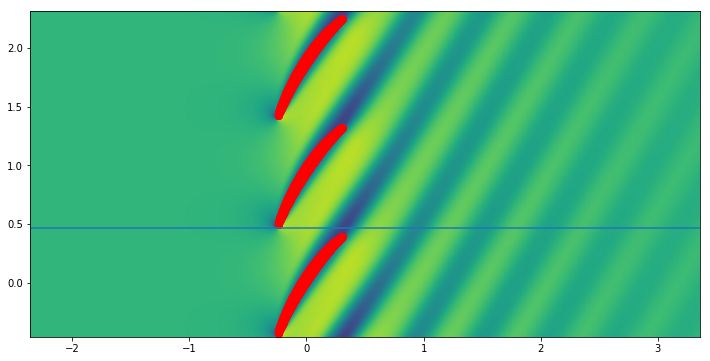

In [10]:
u0 = iR.dot(q0)[:n*(m-1)].reshape((n,m-1))
plt.figure(figsize=(12,6))
X, Y = np.meshgrid(x, y)
plt.pcolormesh(xu, yu, u0, shading='gouraud');
plt.plot(xi[:lP], eta[:lP], 'ro-');
plt.plot(xi[lP:2*lP], eta[lP:2*lP], 'ro-');
plt.plot(xi[2*lP:3*lP], eta[2*lP:3*lP], 'ro-');
plt.plot([x[0], x[-1]], [y[0]+height, y[0]+height])
plt.axis('equal')
plt.xlim(-1, 2)
#plt.ylim(0.2, 0.6)

Base flow

In [11]:
from linpfuncs import *
U0 = iR.dot(q0)

Linearization

In [12]:
from linpfuncs import *
Nh = linearize_advection_hat (dx, dy, dxp, dyp, U0, uW, uE, vW, vE, test=True)
N = Mh.dot(Nh.dot(iR))

In [13]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

In [14]:
# B q^(n+1) = A q^n + Mh f
# Mh is also useful for the inner product

dempty = sp.coo_matrix((Q.shape[1], Q.shape[1]))
oempty = sp.coo_matrix(Q.shape)
MM = sp.bmat([[A, Q],[Q.T, dempty]]).tocsr()
CC = -sp.bmat([[B-1.5*N, oempty], [oempty.T, dempty]]).tocsr()
KK = -sp.bmat([[0.5*N, oempty], [oempty.T, dempty]]).tocsr()

In [15]:
su = nP*(m-1)
svp = nP*m
sxe = lP

idx1 = np.r_[                             : su, 
             3*su                         : 3*su+svp, 
             3*su + 3*svp                 : 3*su+3*svp + svp,
             3*su + 6*svp                 : 3*su+6*svp + sxe,
             3*su + 6*svp + 3*sxe         : 3*su+6*svp + 3*sxe + sxe]
idx2 = np.r_[su                           : 2*su,
             3*su + svp                   : 3*su+2*svp, 
             3*su + 3*svp + svp           : 3*su+3*svp + 2*svp,
             3*su + 6*svp + sxe           : 3*su+6*svp + 2*sxe,
             3*su + 6*svp + 3*sxe + sxe   : 3*su+6*svp + 3*sxe + 2*sxe]
idx3 = np.r_[2*su                         : 3*su,
             3*su + 2*svp                 : 3*su+3*svp, 
             3*su + 3*svp + 2*svp         : 3*su+3*svp + 3*svp,
             3*su + 6*svp + 2*sxe         : 3*su+6*svp + 3*sxe,
             3*su + 6*svp + 3*sxe + 2*sxe : 3*su+6*svp + 3*sxe + 3*sxe]

perm = np.r_[idx1, idx2, idx3]
P = sp.eye(len(perm)).tocsr()[perm,:]

#o = np.zeros_like(perm)
#o [su+2*svp+2*sxe+1]=1
#print(P.T.dot(o)[su+1])

MM = P.dot(MM.dot(P.T))
CC = P.dot(CC.dot(P.T))
KK = P.dot(KK.dot(P.T))

In [16]:
IAn = sp.eye(su+2*svp+2*sxe)
ZAn = sp.coo_matrix((su+2*svp+2*sxe,su+2*svp+2*sxe))

S1 = sp.bmat([[IAn, ZAn, ZAn]])
S2 = sp.bmat([[ZAn, IAn, ZAn]])
S3 = sp.bmat([[ZAn, ZAn, IAn]])

M11 = S1.dot(MM.dot(S1.T))
M12 = S1.dot(MM.dot(S2.T))
M13 = S1.dot(MM.dot(S3.T))

M21 = S2.dot(MM.dot(S1.T))
M22 = S2.dot(MM.dot(S2.T))
M23 = S2.dot(MM.dot(S3.T))

M31 = S3.dot(MM.dot(S1.T))
M32 = S3.dot(MM.dot(S2.T))
M33 = S3.dot(MM.dot(S3.T))

C11 = S1.dot(CC.dot(S1.T))
C12 = S1.dot(CC.dot(S2.T))
C13 = S1.dot(CC.dot(S3.T))

C21 = S2.dot(CC.dot(S1.T))
C22 = S2.dot(CC.dot(S2.T))
C23 = S2.dot(CC.dot(S3.T))

C31 = S3.dot(CC.dot(S1.T))
C32 = S3.dot(CC.dot(S2.T))
C33 = S3.dot(CC.dot(S3.T))

K11 = S1.dot(KK.dot(S1.T))
K12 = S1.dot(KK.dot(S2.T))
K13 = S1.dot(KK.dot(S3.T))

K21 = S2.dot(KK.dot(S1.T))
K22 = S2.dot(KK.dot(S2.T))
K23 = S2.dot(KK.dot(S3.T))

K31 = S3.dot(KK.dot(S1.T))
K32 = S3.dot(KK.dot(S2.T))
K33 = S3.dot(KK.dot(S3.T))

IIn = sp.bmat([[sp.eye(su+svp), sp.coo_matrix((su+svp, svp+2*sxe))]])

In [17]:
print(spla.norm(M11 - M22), spla.norm(M11 - M33), spla.norm(M22 - M33))
print(spla.norm(M12 - M23), spla.norm(M12 - M31), spla.norm(M12 - M31))
print(spla.norm(M13 - M21), spla.norm(M13 - M32), spla.norm(M21 - M32))

4.05503384577e-08 8.66111752623e-08 8.11499273943e-08
5.53099015071e-10 2.77585097795e-10 2.77585097795e-10
8.34407471737e-10 2.82586543935e-10 5.69984974134e-10


In [18]:
print(spla.norm(C11 - C22), spla.norm(C11 - C33), spla.norm(C22 - C33))
print(spla.norm(C12 - C23), spla.norm(C12 - C31), spla.norm(C12 - C31))
print(spla.norm(C13 - C21), spla.norm(C13 - C32), spla.norm(C21 - C32))

2.42762332754e-08 4.84328914898e-08 4.78540093374e-08
5.53245357335e-10 1.41718579521e-09 1.41718579521e-09
2.47929937356e-09 1.93148512242e-09 6.16060846757e-10


In [19]:
print(spla.norm(K11 - K22), spla.norm(K11 - K33), spla.norm(K22 - K33))
print(spla.norm(K12 - K23), spla.norm(K12 - K31), spla.norm(K12 - K31))
print(spla.norm(K13 - K21), spla.norm(K13 - K32), spla.norm(K21 - K32))

3.92064106246e-09 7.07492573349e-09 7.71026793411e-09
2.22990424348e-13 5.60795580754e-10 5.60795580754e-10
5.53263758022e-10 5.53265067917e-10 7.87292893063e-11


In [20]:
Mk = np.zeros(M11.shape[0])
Mk[nP*(m-1) + nP*m : nP*(m-1) + 2*nP*m]=1.0
tmp = (M11+M12+M13).dot(Mk)
print(la.norm(tmp))

0.0


In [24]:
from PetscBinaryIO import PetscBinaryIO

dest = '1-ExtractMatrices/'

PetscBinaryIO().writeMatSciPy(open(dest+'M1.dat','w'), M11)
PetscBinaryIO().writeMatSciPy(open(dest+'M2.dat','w'), M12)
PetscBinaryIO().writeMatSciPy(open(dest+'M3.dat','w'), M13)
PetscBinaryIO().writeMatSciPy(open(dest+'C1.dat','w'), C11)
PetscBinaryIO().writeMatSciPy(open(dest+'C2.dat','w'), C12)
PetscBinaryIO().writeMatSciPy(open(dest+'C3.dat','w'), C13)
PetscBinaryIO().writeMatSciPy(open(dest+'K1.dat','w'), K11)
PetscBinaryIO().writeMatSciPy(open(dest+'K2.dat','w'), K12)
PetscBinaryIO().writeMatSciPy(open(dest+'K3.dat','w'), K13)
PetscBinaryIO().writeMatSciPy(open(dest+'I.dat','w'), IIn)
PetscBinaryIO().writeVec(open(dest+'Mk.dat','w'), Mk)
PetscBinaryIO().writeVec(open(dest+'Rh12.dat','w'), np.sqrt(R1))
PetscBinaryIO().writeVec(open(dest+'Mh12.dat','w'), np.sqrt(Mh1))